In [13]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import os
import sys
sys.path.append('/home/nas2/biod/zhencaiwei/RegChat-main/Code/')
from DGI_HGCN.models import DGI, LogReg
from DGI_HGCN.utils import process
from Plot import Visualization
import pickle as pkl
import ast
import pandas as pd
import random
from Attscore_mat import RegChat_HDGI_train, data_preprocess, compute_attscore_mat
import json 
import pickle
from tqdm import tqdm
from scipy.sparse import lil_matrix
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
import math
import scanpy as sc
import anndata
from scipy import stats

torch.backends.cudnn.enable =True
torch.backends.cudnn.benchmark = True
os.environ['CUDA_LAUNCH_BLOCKING'] ='1'

# Load data

In [2]:
path = '/home/nas2/biod/zhencaiwei/RegChat-main/Simudata/'
path_nt = '/home/nas2/biod/zhencaiwei/RegChat-main/Simudata/simulated_data_000/'

In [3]:
signaling_pathway = pd.read_csv(path + 'signaling_pathway.csv')
gene_cell_mat = pd.read_csv(path_nt + 'simulated_adata_ST_00.csv',sep=',',index_col=0)
coord = pd.read_csv(path_nt + 'coordinates_df.csv',sep='\t')
cell_type = pd.read_csv(path_nt + 'spot_CT1_CT3_label_str.txt',sep='\t')
cell_type_num = pd.read_csv(path_nt + 'spot_CT1_CT3_label_num.txt',sep='\t')
adjs_names_list = np.loadtxt(path_nt+'simulated_adj_files_all.txt', dtype='str')

# Generate adj matrix

In [4]:
compute_attscore_mat.generate_adj_matrix(gene_cell_mat, signaling_pathway, path_nt, coord)

100%|██████████| 31/31 [00:00<00:00, 1864.19it/s]


There are 490 cells
/home/nas2/biod/zhencaiwei/RegChat-main/Simudata/simulated_data_000/clrfgc_adj/L0_R3_F12_G9_adj.pickle has been saved
/home/nas2/biod/zhencaiwei/RegChat-main/Simudata/simulated_data_000/clrfgc_adj/L0_R8_F12_G15_adj.pickle has been saved
/home/nas2/biod/zhencaiwei/RegChat-main/Simudata/simulated_data_000/clrfgc_adj/L1_R1_F1_G1_adj.pickle has been saved
/home/nas2/biod/zhencaiwei/RegChat-main/Simudata/simulated_data_000/clrfgc_adj/L1_R6_F17_G23_adj.pickle has been saved
/home/nas2/biod/zhencaiwei/RegChat-main/Simudata/simulated_data_000/clrfgc_adj/L2_R0_F4_G4_adj.pickle has been saved
/home/nas2/biod/zhencaiwei/RegChat-main/Simudata/simulated_data_000/clrfgc_adj/L3_R0_F4_G4_adj.pickle has been saved
/home/nas2/biod/zhencaiwei/RegChat-main/Simudata/simulated_data_000/clrfgc_adj/L4_R3_F5_G6_adj.pickle has been saved
/home/nas2/biod/zhencaiwei/RegChat-main/Simudata/simulated_data_000/clrfgc_adj/L4_R5_F5_G7_adj.pickle has been saved
/home/nas2/biod/zhencaiwei/RegChat-main

# Get attscore

In [9]:
scell_types = ['CT3']
rcell_types = ['CT3']
outs_symbol = path_nt + 'outs/'
os.makedirs(outs_symbol, exist_ok=True) 
adj_dir = path_nt + 'clrfgc_adj/'

In [10]:
'''load adjs matrix'''
adjs = []
for adj_name in adjs_names_list:
    with open(adj_dir + adj_name, 'rb') as f:
        adj = pkl.load(f)
    f.close
    adjs.append(adj) 
'''load labels csv, labels----->one hot encoding'''
numeric_labels = cell_type_num['label_num']
hdgi_labels = torch.tensor(numeric_labels)
numeric_labels_set = set(numeric_labels)
hdgi_nb_class = len(numeric_labels_set)
print('----hdgi_nb_class-----', hdgi_nb_class)    

'''create temp dirs'''
current_datetime = datetime.datetime.now()
current_time_str = current_datetime.strftime("%Y-%m-%d-%H-%M-%S/")
folder_name = current_time_str
path_temp = os.path.join(outs_symbol+'clrfgc_temp/',  folder_name)
os.makedirs(path_temp)
    
metapath_attention_lists = {metapath: [] for metapath in adjs_names_list}
metapath_attention_zscore_lists = {metapath: [] for metapath in adjs_names_list}

----hdgi_nb_class----- 3


100%|██████████| 490/490 [00:00<00:00, 21678.28it/s]
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metapath_weight = torch.tensor(metapath_weight).to(device)


sc_type CT3
rc_type CT3
float_path_weight [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
The variable adjs occupies 312 bytes in memory.
The variable sp_nor_adjs occupies 80 bytes in memory.
Model memory usage: 0 bytes
Using CUDA
Epoch: [1/10000], Loss: 0.6931, Train Accuracy: 0.0833, Val Accuracy: 0.0800
Epoch: [2/10000], Loss: 0.6931, Train Accuracy: 0.3900, Val Accuracy: 0.3300
Epoch: [3/10000], Loss: 0.6930, Train Accuracy: 0.7900, Val Accuracy: 0.7800
Epoch: [4/10000], Loss: 0.6929, Train Accuracy: 0.2900, Val Accuracy: 0.3100
Epoch: [5/10000], Loss: 0.6929, Train Accuracy: 0.3300, Val Accuracy: 0.3600
Epoch: [6/10000], Loss: 0.6928, Train Accuracy: 0.2900, Val Accuracy: 0.2900
Epoch: [7/10000], Loss: 0.6928, Train Accuracy: 0.5700, Val Accuracy: 0.5700
Epoch: [8/10000], Loss: 0.6927, Train Accuracy: 0.5033, Val Accuracy: 0.4900
Epoch: [9/10000], Loss: 0.6926, Train Accuracy: 0.2700, Val Accuracy: 0.2700
Epoch: [10/10000], Loss: 0.692

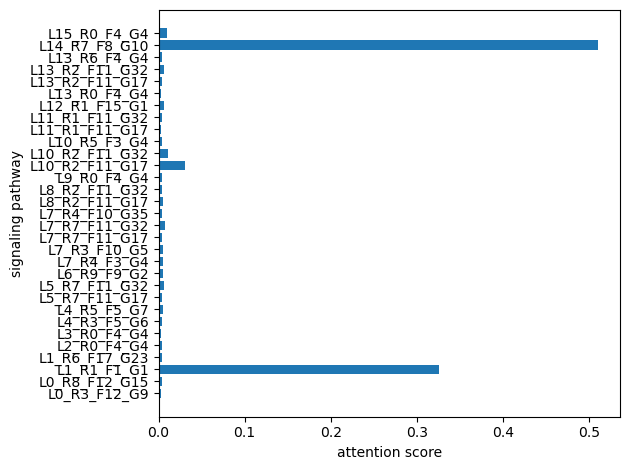

AUC: 0.9667
The variable adjs occupies 312 bytes in memory.
The variable sp_nor_adjs occupies 80 bytes in memory.
Model memory usage: 0 bytes
Using CUDA


/tmp/ipykernel_2876744/1175651131.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hdgi_para_dict['metapath_weight'] = torch.tensor(hdgi_para_dict['metapath_weight']).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metapath_weight = torch.tensor(metapath_weight).to(device

Epoch: [1/10000], Loss: 0.6932, Train Accuracy: 0.1900, Val Accuracy: 0.2100
Epoch: [2/10000], Loss: 0.6932, Train Accuracy: 0.3700, Val Accuracy: 0.3300
Epoch: [3/10000], Loss: 0.6931, Train Accuracy: 0.2233, Val Accuracy: 0.2800
Epoch: [4/10000], Loss: 0.6931, Train Accuracy: 0.2967, Val Accuracy: 0.3200
Epoch: [5/10000], Loss: 0.6931, Train Accuracy: 0.0900, Val Accuracy: 0.0900
Epoch: [6/10000], Loss: 0.6930, Train Accuracy: 0.3000, Val Accuracy: 0.3200
Epoch: [7/10000], Loss: 0.6930, Train Accuracy: 0.2967, Val Accuracy: 0.3100
Epoch: [8/10000], Loss: 0.6929, Train Accuracy: 0.1267, Val Accuracy: 0.1400
Epoch: [9/10000], Loss: 0.6929, Train Accuracy: 0.2967, Val Accuracy: 0.3200
Epoch: [10/10000], Loss: 0.6928, Train Accuracy: 0.1967, Val Accuracy: 0.2000
Epoch: [11/10000], Loss: 0.6927, Train Accuracy: 0.5100, Val Accuracy: 0.4400
Epoch: [12/10000], Loss: 0.6926, Train Accuracy: 0.0300, Val Accuracy: 0.0400
Epoch: [13/10000], Loss: 0.6925, Train Accuracy: 0.0933, Val Accuracy: 0.

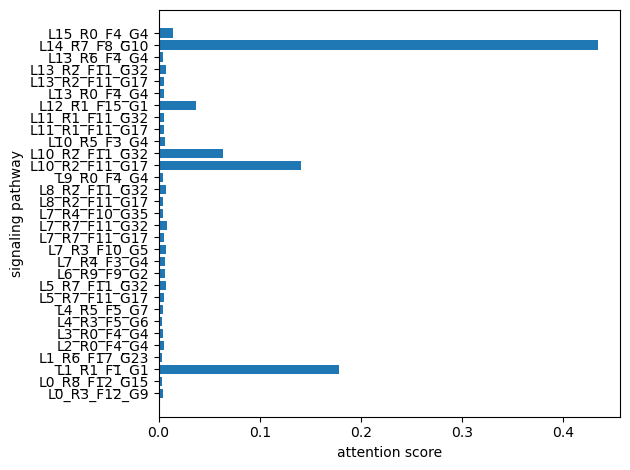

AUC: 0.9667
The variable adjs occupies 312 bytes in memory.
The variable sp_nor_adjs occupies 80 bytes in memory.
Model memory usage: 0 bytes
Using CUDA


/tmp/ipykernel_2876744/1175651131.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hdgi_para_dict['metapath_weight'] = torch.tensor(hdgi_para_dict['metapath_weight']).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metapath_weight = torch.tensor(metapath_weight).to(device

Epoch: [1/10000], Loss: 0.6931, Train Accuracy: 0.3100, Val Accuracy: 0.2400
Epoch: [2/10000], Loss: 0.6930, Train Accuracy: 0.0767, Val Accuracy: 0.1000
Epoch: [3/10000], Loss: 0.6930, Train Accuracy: 0.2867, Val Accuracy: 0.2400
Epoch: [4/10000], Loss: 0.6929, Train Accuracy: 0.0933, Val Accuracy: 0.1300
Epoch: [5/10000], Loss: 0.6928, Train Accuracy: 0.0100, Val Accuracy: 0.0000
Epoch: [6/10000], Loss: 0.6926, Train Accuracy: 0.3167, Val Accuracy: 0.2400
Epoch: [7/10000], Loss: 0.6926, Train Accuracy: 0.0900, Val Accuracy: 0.0800
Epoch: [8/10000], Loss: 0.6925, Train Accuracy: 0.8533, Val Accuracy: 0.8600
Epoch: [9/10000], Loss: 0.6925, Train Accuracy: 0.8267, Val Accuracy: 0.8300
Epoch: [10/10000], Loss: 0.6923, Train Accuracy: 0.2533, Val Accuracy: 0.2200
Epoch: [11/10000], Loss: 0.6922, Train Accuracy: 0.2233, Val Accuracy: 0.1800
Epoch: [12/10000], Loss: 0.6920, Train Accuracy: 0.6067, Val Accuracy: 0.6600
Epoch: [13/10000], Loss: 0.6917, Train Accuracy: 0.2133, Val Accuracy: 0.

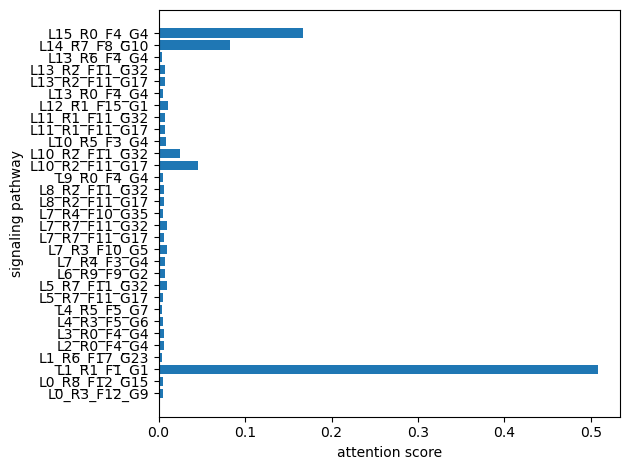

AUC: 1.0000
The variable adjs occupies 312 bytes in memory.
The variable sp_nor_adjs occupies 80 bytes in memory.
Model memory usage: 0 bytes
Using CUDA


/tmp/ipykernel_2876744/1175651131.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hdgi_para_dict['metapath_weight'] = torch.tensor(hdgi_para_dict['metapath_weight']).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metapath_weight = torch.tensor(metapath_weight).to(device

Epoch: [1/10000], Loss: 0.6932, Train Accuracy: 0.1767, Val Accuracy: 0.2100
Epoch: [2/10000], Loss: 0.6931, Train Accuracy: 0.6933, Val Accuracy: 0.5900
Epoch: [3/10000], Loss: 0.6930, Train Accuracy: 0.8200, Val Accuracy: 0.8500
Epoch: [4/10000], Loss: 0.6930, Train Accuracy: 0.8600, Val Accuracy: 0.8800
Epoch: [5/10000], Loss: 0.6929, Train Accuracy: 0.1833, Val Accuracy: 0.2000
Epoch: [6/10000], Loss: 0.6929, Train Accuracy: 0.0067, Val Accuracy: 0.0200
Epoch: [7/10000], Loss: 0.6928, Train Accuracy: 0.0067, Val Accuracy: 0.0100
Epoch: [8/10000], Loss: 0.6927, Train Accuracy: 0.6333, Val Accuracy: 0.6500
Epoch: [9/10000], Loss: 0.6927, Train Accuracy: 0.5900, Val Accuracy: 0.5000
Epoch: [10/10000], Loss: 0.6926, Train Accuracy: 0.2200, Val Accuracy: 0.2600
Epoch: [11/10000], Loss: 0.6925, Train Accuracy: 0.8567, Val Accuracy: 0.8800
Epoch: [12/10000], Loss: 0.6923, Train Accuracy: 0.1167, Val Accuracy: 0.0900
Epoch: [13/10000], Loss: 0.6922, Train Accuracy: 0.1367, Val Accuracy: 0.

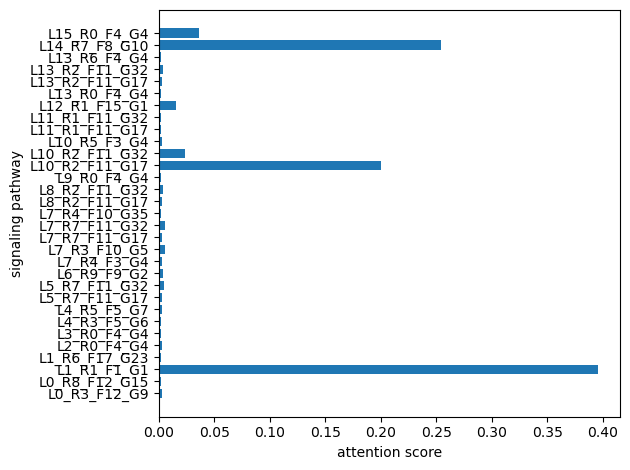

AUC: 1.0000
The variable adjs occupies 312 bytes in memory.
The variable sp_nor_adjs occupies 80 bytes in memory.
Model memory usage: 0 bytes
Using CUDA


/tmp/ipykernel_2876744/1175651131.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hdgi_para_dict['metapath_weight'] = torch.tensor(hdgi_para_dict['metapath_weight']).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metapath_weight = torch.tensor(metapath_weight).to(device

Epoch: [1/10000], Loss: 0.6931, Train Accuracy: 0.6033, Val Accuracy: 0.5200
Epoch: [2/10000], Loss: 0.6931, Train Accuracy: 0.3300, Val Accuracy: 0.3300
Epoch: [3/10000], Loss: 0.6930, Train Accuracy: 0.0167, Val Accuracy: 0.0100
Epoch: [4/10000], Loss: 0.6930, Train Accuracy: 0.5433, Val Accuracy: 0.4500
Epoch: [5/10000], Loss: 0.6929, Train Accuracy: 0.1967, Val Accuracy: 0.2100
Epoch: [6/10000], Loss: 0.6928, Train Accuracy: 0.6000, Val Accuracy: 0.6100
Epoch: [7/10000], Loss: 0.6928, Train Accuracy: 0.5733, Val Accuracy: 0.5600
Epoch: [8/10000], Loss: 0.6927, Train Accuracy: 0.1300, Val Accuracy: 0.0900
Epoch: [9/10000], Loss: 0.6926, Train Accuracy: 0.5900, Val Accuracy: 0.5800
Epoch: [10/10000], Loss: 0.6925, Train Accuracy: 0.0867, Val Accuracy: 0.0900
Epoch: [11/10000], Loss: 0.6924, Train Accuracy: 0.3100, Val Accuracy: 0.3200
Epoch: [12/10000], Loss: 0.6923, Train Accuracy: 0.4833, Val Accuracy: 0.3600
Epoch: [13/10000], Loss: 0.6922, Train Accuracy: 0.1800, Val Accuracy: 0.

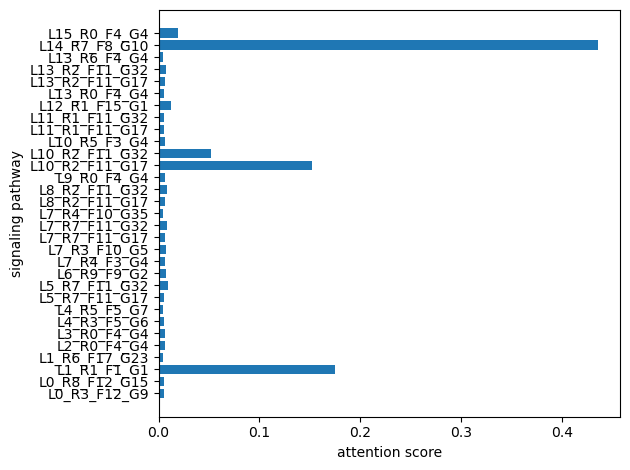

AUC: 0.9667
The variable adjs occupies 312 bytes in memory.
The variable sp_nor_adjs occupies 80 bytes in memory.
Model memory usage: 0 bytes
Using CUDA


/tmp/ipykernel_2876744/1175651131.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hdgi_para_dict['metapath_weight'] = torch.tensor(hdgi_para_dict['metapath_weight']).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metapath_weight = torch.tensor(metapath_weight).to(device

Epoch: [1/10000], Loss: 0.6931, Train Accuracy: 0.0800, Val Accuracy: 0.0800
Epoch: [2/10000], Loss: 0.6931, Train Accuracy: 0.3333, Val Accuracy: 0.2900
Epoch: [3/10000], Loss: 0.6931, Train Accuracy: 0.1833, Val Accuracy: 0.2000
Epoch: [4/10000], Loss: 0.6930, Train Accuracy: 0.3700, Val Accuracy: 0.3800
Epoch: [5/10000], Loss: 0.6930, Train Accuracy: 0.6800, Val Accuracy: 0.6700
Epoch: [6/10000], Loss: 0.6929, Train Accuracy: 0.6200, Val Accuracy: 0.5800
Epoch: [7/10000], Loss: 0.6929, Train Accuracy: 0.4967, Val Accuracy: 0.5000
Epoch: [8/10000], Loss: 0.6928, Train Accuracy: 0.1567, Val Accuracy: 0.1800
Epoch: [9/10000], Loss: 0.6927, Train Accuracy: 0.2533, Val Accuracy: 0.3100
Epoch: [10/10000], Loss: 0.6926, Train Accuracy: 0.0533, Val Accuracy: 0.0800
Epoch: [11/10000], Loss: 0.6925, Train Accuracy: 0.4367, Val Accuracy: 0.4800
Epoch: [12/10000], Loss: 0.6925, Train Accuracy: 0.6067, Val Accuracy: 0.5700
Epoch: [13/10000], Loss: 0.6924, Train Accuracy: 0.3000, Val Accuracy: 0.

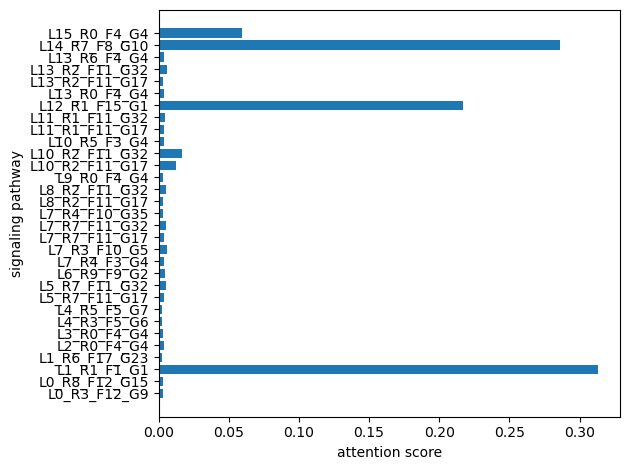

AUC: 1.0000
The variable adjs occupies 312 bytes in memory.
The variable sp_nor_adjs occupies 80 bytes in memory.
Model memory usage: 0 bytes
Using CUDA


/tmp/ipykernel_2876744/1175651131.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hdgi_para_dict['metapath_weight'] = torch.tensor(hdgi_para_dict['metapath_weight']).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metapath_weight = torch.tensor(metapath_weight).to(device

Epoch: [1/10000], Loss: 0.6932, Train Accuracy: 0.1100, Val Accuracy: 0.0600
Epoch: [2/10000], Loss: 0.6932, Train Accuracy: 0.1133, Val Accuracy: 0.0600
Epoch: [3/10000], Loss: 0.6931, Train Accuracy: 0.6567, Val Accuracy: 0.6200
Epoch: [4/10000], Loss: 0.6930, Train Accuracy: 0.1100, Val Accuracy: 0.1000
Epoch: [5/10000], Loss: 0.6930, Train Accuracy: 0.6467, Val Accuracy: 0.6400
Epoch: [6/10000], Loss: 0.6930, Train Accuracy: 0.7500, Val Accuracy: 0.8300
Epoch: [7/10000], Loss: 0.6929, Train Accuracy: 0.2600, Val Accuracy: 0.3100
Epoch: [8/10000], Loss: 0.6928, Train Accuracy: 0.7133, Val Accuracy: 0.6700
Epoch: [9/10000], Loss: 0.6927, Train Accuracy: 0.6133, Val Accuracy: 0.6000
Epoch: [10/10000], Loss: 0.6927, Train Accuracy: 0.1267, Val Accuracy: 0.1300
Epoch: [11/10000], Loss: 0.6926, Train Accuracy: 0.8333, Val Accuracy: 0.8800
Epoch: [12/10000], Loss: 0.6925, Train Accuracy: 0.2833, Val Accuracy: 0.3300
Epoch: [13/10000], Loss: 0.6924, Train Accuracy: 0.6500, Val Accuracy: 0.

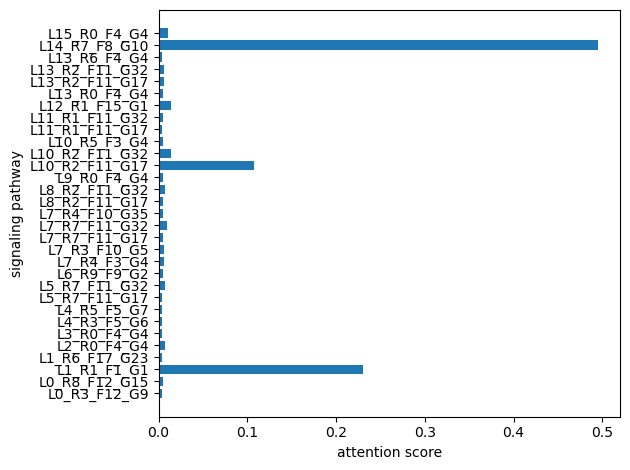

AUC: 0.9667
The variable adjs occupies 312 bytes in memory.
The variable sp_nor_adjs occupies 80 bytes in memory.
Model memory usage: 0 bytes
Using CUDA


/tmp/ipykernel_2876744/1175651131.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hdgi_para_dict['metapath_weight'] = torch.tensor(hdgi_para_dict['metapath_weight']).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metapath_weight = torch.tensor(metapath_weight).to(device

Epoch: [1/10000], Loss: 0.6932, Train Accuracy: 0.1767, Val Accuracy: 0.2500
Epoch: [2/10000], Loss: 0.6931, Train Accuracy: 0.0933, Val Accuracy: 0.0500
Epoch: [3/10000], Loss: 0.6930, Train Accuracy: 0.2000, Val Accuracy: 0.1900
Epoch: [4/10000], Loss: 0.6930, Train Accuracy: 0.2800, Val Accuracy: 0.3500
Epoch: [5/10000], Loss: 0.6929, Train Accuracy: 0.1633, Val Accuracy: 0.1500
Epoch: [6/10000], Loss: 0.6929, Train Accuracy: 0.1833, Val Accuracy: 0.2500
Epoch: [7/10000], Loss: 0.6928, Train Accuracy: 0.0433, Val Accuracy: 0.0400
Epoch: [8/10000], Loss: 0.6927, Train Accuracy: 0.3067, Val Accuracy: 0.3700
Epoch: [9/10000], Loss: 0.6927, Train Accuracy: 0.7400, Val Accuracy: 0.8000
Epoch: [10/10000], Loss: 0.6926, Train Accuracy: 0.0500, Val Accuracy: 0.0500
Epoch: [11/10000], Loss: 0.6924, Train Accuracy: 0.0900, Val Accuracy: 0.0500
Epoch: [12/10000], Loss: 0.6923, Train Accuracy: 0.0967, Val Accuracy: 0.0500
Epoch: [13/10000], Loss: 0.6922, Train Accuracy: 0.0733, Val Accuracy: 0.

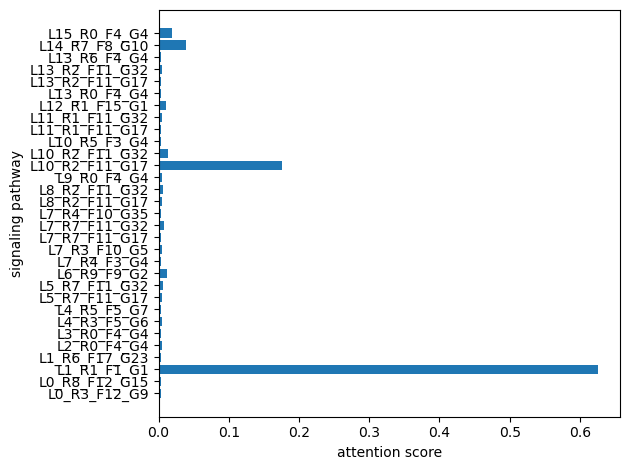

AUC: 1.0000
The variable adjs occupies 312 bytes in memory.
The variable sp_nor_adjs occupies 80 bytes in memory.
Model memory usage: 0 bytes
Using CUDA


/tmp/ipykernel_2876744/1175651131.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hdgi_para_dict['metapath_weight'] = torch.tensor(hdgi_para_dict['metapath_weight']).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metapath_weight = torch.tensor(metapath_weight).to(device

Epoch: [1/10000], Loss: 0.6932, Train Accuracy: 0.0933, Val Accuracy: 0.0500
Epoch: [2/10000], Loss: 0.6932, Train Accuracy: 0.1600, Val Accuracy: 0.1300
Epoch: [3/10000], Loss: 0.6931, Train Accuracy: 0.6100, Val Accuracy: 0.6700
Epoch: [4/10000], Loss: 0.6930, Train Accuracy: 0.2967, Val Accuracy: 0.2800
Epoch: [5/10000], Loss: 0.6930, Train Accuracy: 0.1200, Val Accuracy: 0.0600
Epoch: [6/10000], Loss: 0.6930, Train Accuracy: 0.6400, Val Accuracy: 0.7000
Epoch: [7/10000], Loss: 0.6929, Train Accuracy: 0.2600, Val Accuracy: 0.2500
Epoch: [8/10000], Loss: 0.6928, Train Accuracy: 0.2633, Val Accuracy: 0.2700
Epoch: [9/10000], Loss: 0.6928, Train Accuracy: 0.3767, Val Accuracy: 0.3200
Epoch: [10/10000], Loss: 0.6927, Train Accuracy: 0.6067, Val Accuracy: 0.6700
Epoch: [11/10000], Loss: 0.6926, Train Accuracy: 0.2400, Val Accuracy: 0.2500
Epoch: [12/10000], Loss: 0.6926, Train Accuracy: 0.5333, Val Accuracy: 0.6000
Epoch: [13/10000], Loss: 0.6924, Train Accuracy: 0.3000, Val Accuracy: 0.

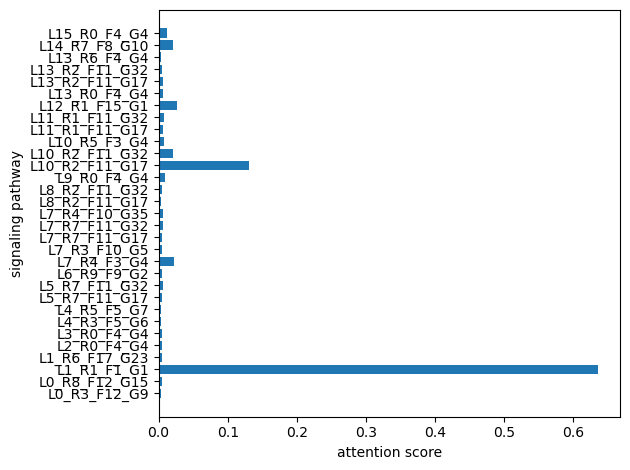

AUC: 1.0000
The variable adjs occupies 312 bytes in memory.
The variable sp_nor_adjs occupies 80 bytes in memory.
Model memory usage: 0 bytes
Using CUDA


/tmp/ipykernel_2876744/1175651131.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hdgi_para_dict['metapath_weight'] = torch.tensor(hdgi_para_dict['metapath_weight']).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features).to(device)
/home/nas2/biod/zhencaiwei/RegChat-main/Code/Attscore_mat/RegChat_HDGI_train.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  metapath_weight = torch.tensor(metapath_weight).to(device

Epoch: [1/10000], Loss: 0.6932, Train Accuracy: 0.1100, Val Accuracy: 0.1200
Epoch: [2/10000], Loss: 0.6932, Train Accuracy: 0.0933, Val Accuracy: 0.1100
Epoch: [3/10000], Loss: 0.6931, Train Accuracy: 0.0933, Val Accuracy: 0.0500
Epoch: [4/10000], Loss: 0.6930, Train Accuracy: 0.2567, Val Accuracy: 0.3100
Epoch: [5/10000], Loss: 0.6930, Train Accuracy: 0.0933, Val Accuracy: 0.0500
Epoch: [6/10000], Loss: 0.6930, Train Accuracy: 0.3500, Val Accuracy: 0.4900
Epoch: [7/10000], Loss: 0.6929, Train Accuracy: 0.1033, Val Accuracy: 0.0500
Epoch: [8/10000], Loss: 0.6928, Train Accuracy: 0.0933, Val Accuracy: 0.0500
Epoch: [9/10000], Loss: 0.6928, Train Accuracy: 0.5867, Val Accuracy: 0.6100
Epoch: [10/10000], Loss: 0.6927, Train Accuracy: 0.6200, Val Accuracy: 0.6000
Epoch: [11/10000], Loss: 0.6926, Train Accuracy: 0.2700, Val Accuracy: 0.2900
Epoch: [12/10000], Loss: 0.6925, Train Accuracy: 0.2900, Val Accuracy: 0.3500
Epoch: [13/10000], Loss: 0.6925, Train Accuracy: 0.8633, Val Accuracy: 0.

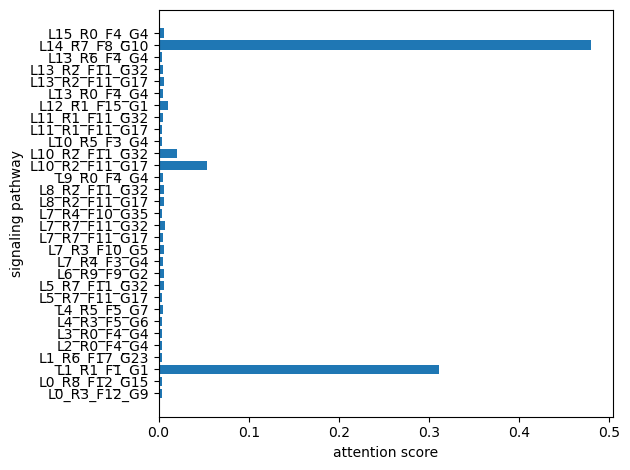

AUC: 0.9667
CT3_CT3_auc_list [0.9666666666666667, 0.9666666666666667, 1.0, 1.0, 0.9666666666666667, 1.0, 0.9666666666666667, 1.0, 1.0, 0.9666666666666667]
CT3_CT3_att_list           0         1         2         3         4         5         6   \
0   1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1   0.000185  0.000398  0.353561  0.000227  0.000176  0.000127  0.000422   
2   0.000005  0.000004  0.215086  0.000004  0.000011  0.000005  0.000003   
3   0.000153  0.000136  0.702234  0.000086  0.000228  0.000317  0.000086   
4   0.000020  0.000008  0.437066  0.000011  0.000017  0.000010  0.000007   
5   0.000031  0.000029  0.226178  0.000025  0.000049  0.000040  0.000031   
6   0.000015  0.000013  0.273389  0.000013  0.000020  0.000013  0.000014   
7   0.000006  0.000010  0.268855  0.000004  0.000027  0.000006  0.000005   
8   0.000488  0.000881  0.741843  0.000323  0.001153  0.000716  0.001337   
9   0.000927  0.000890  0.746555  0.001074  0.001190  0.001062  0.00

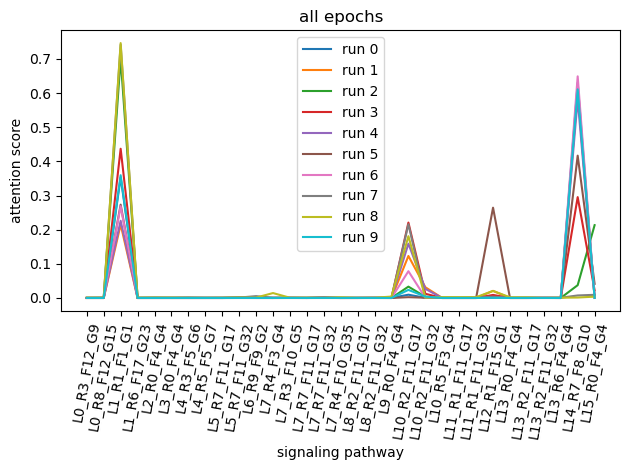

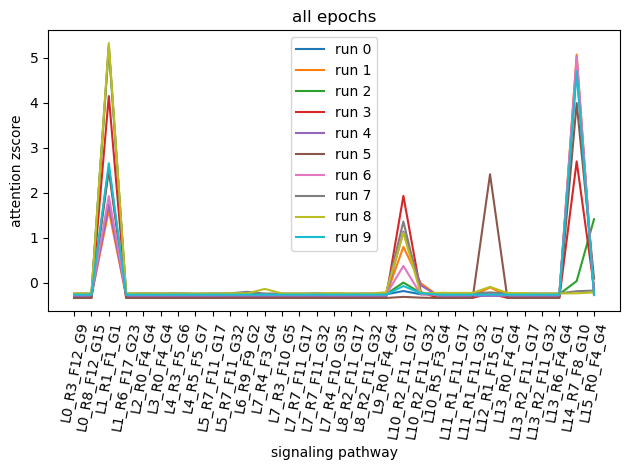

auc_avg 0.9833333333333334


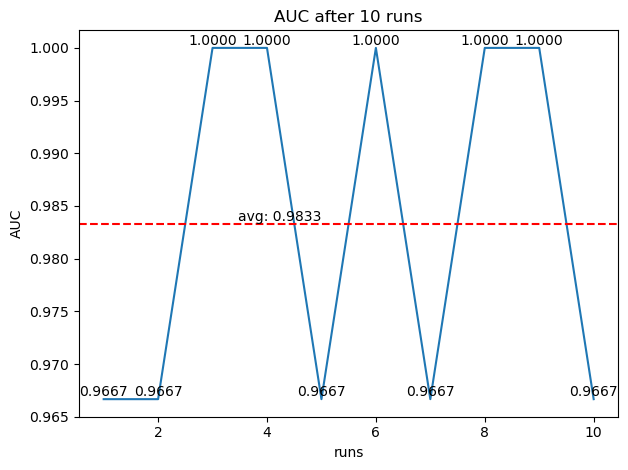

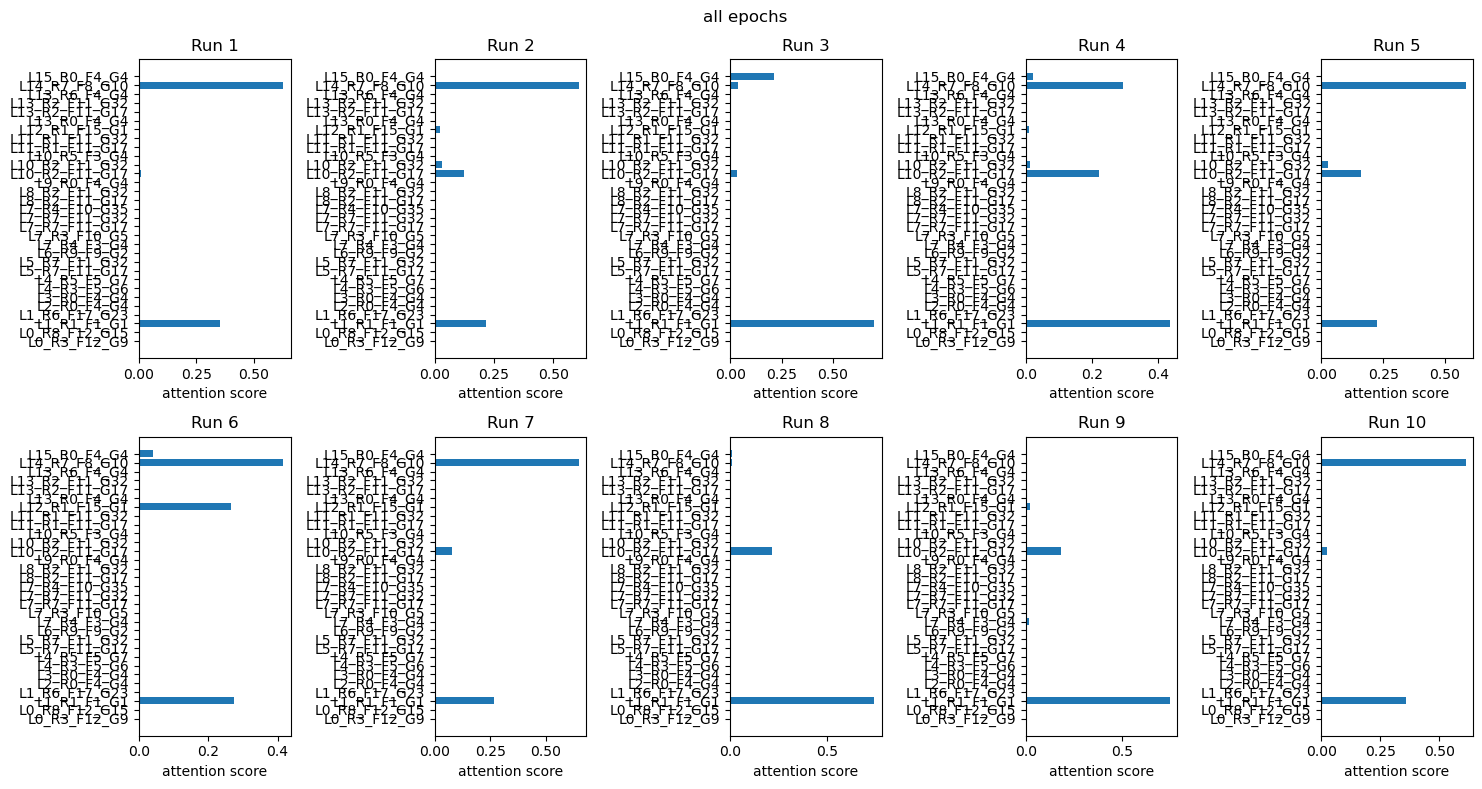

In [11]:
for sc_type in scell_types:
    for rc_type in rcell_types:
        masked_gene_cell_mat, df_cell, fixed_idx = compute_attscore_mat.generate_cell_node(sc_type, rc_type, 
                                                                                           signaling_pathway, 
                                                                                           gene_cell_mat, cell_type)
        float_path_weight = [1]*len(signaling_pathway)
        
        del masked_gene_cell_mat
        print('sc_type', sc_type)
        print('rc_type', rc_type)
        print('float_path_weight', float_path_weight)


        '''Convert the feature types in the dataframe, converting strings to lists'''
        cell_fea = []
        for line in df_cell['feature']:
            line = [float(i) for i in line]
            cell_fea.append(line)


        '''traning params'''
        hdgi_para_dict = {
            'original_idx_len':gene_cell_mat.shape[1],
            'train_idx_len':300,#int(gene_cell_mat.shape[1]*0.2)
            'test_idx_len':100,
            'batch_size': 1,
            'nb_epochs': 10000,
            'patience': 50,
            'lr': 0.0008,
            'l2_coef': 0.0,
            'drop_prob': 0.0,
            'hid_units': 64, # output of the GCN dimension
            'shid': 16, # input dimension of semantic-level attention
            'sparse': True,
            'preprocess_feat': True,
            'nonlinearity': 'prelu', # special name to separate parameters
            'LRpair': 'pathway',
            'noise_value': 0,
            'metapath_weight': float_path_weight,
            'fold_epochs':200,
            'save_dir':path_temp
        }

        '''create cell type dirs'''
        sc_type_now = sc_type.replace(" ", "-")
        sc_type_now = sc_type_now.replace("/", "-")
        rc_type_now = rc_type.replace(" ", "-")
        rc_type_now = rc_type_now.replace("/", "-")
        sc_rc = sc_type_now + '_' + rc_type_now + '/'
        sr_path = os.path.join(outs_symbol+'clrfgc_temp/'+current_time_str,  sc_rc)
        os.makedirs(sr_path,exist_ok=True)
        
        '''create results dirs'''
        embeds_path = os.path.join(sr_path,  'embeds/')
        os.makedirs(embeds_path,exist_ok=True)
        gene_exp_path = os.path.join(sr_path,  'gene_exp/')
        os.makedirs(gene_exp_path,exist_ok=True)

        '''save hdgi_para to json'''
        hdgi_json_path = path + 'hdgi_para.json'
        with open(hdgi_json_path, 'w') as json_file:
            json.dump(hdgi_para_dict, json_file)
            
        '''check the type of tensor(outputs)'''
        outputs = torch.tensor(cell_fea).float()
        del cell_fea
  
            
        '''HDGI---start----'''
        runs = 10
        att_list = []
        auc_list = []
        att_list.append(float_path_weight)
        att_1_sum_list = []
        pre_probs_list = []
        cuda_num = "cuda:4"
        device = torch.device(cuda_num if torch.cuda.is_available() else "cpu")
        for i in range(runs):
            epoch = 1
            if hdgi_para_dict['noise_value'] > 0.0:
                outputs = outputs.cpu().detach().numpy()
                outputs = pd.DataFrame(outputs)
                theta_L_values = np.linspace(0, 0.25, 10) 
                params = data_preprocess.fit_curve(theta_L_values, data_preprocess.calculate_theta_B_for_different_theta_L_values(outputs, hdgi_para_dict['noise_value'], theta_L_values))
                outputs_with_noise = data_preprocess.add_noise_to_dataframe(outputs, hdgi_para_dict['noise_value'], theta_L_values[0])
                outputs = torch.from_numpy(outputs_with_noise.values)
            else:    
                outputs = outputs
            if hdgi_para_dict['preprocess_feat']:
                features = RegChat_HDGI_train.preprocess_features_dense(outputs.cpu().detach().numpy())
                features = torch.tensor(features).to(device)
            else:
                features = outputs
            hdgi_para_dict['metapath_weight'] = torch.tensor(hdgi_para_dict['metapath_weight']).to(device)
            att_1, _, xent_min_loss, embeds = RegChat_HDGI_train.train(features = features, labels = hdgi_labels, 
                                                patience = hdgi_para_dict['patience'], nb_class = hdgi_nb_class, 
                                                hid_units = hdgi_para_dict['hid_units'], shid = hdgi_para_dict['shid'],  
                                                nonlinearity = hdgi_para_dict['nonlinearity'], 
                                                lr = hdgi_para_dict['lr'], l2_coef = hdgi_para_dict['l2_coef'], 
                                                adjs = adjs, sparse = hdgi_para_dict['sparse'], 
                                                nb_epochs = hdgi_para_dict['nb_epochs'], batch_size = hdgi_para_dict['batch_size'],
                                                hgnn_epoch = epoch, metapath_weight = hdgi_para_dict['metapath_weight'], fixed_idx=fixed_idx,
                                                original_idx_len=hdgi_para_dict['original_idx_len'],train_idx_len=hdgi_para_dict['train_idx_len'],
                                                test_idx_len=hdgi_para_dict['test_idx_len'], 
                                                cuda_num=cuda_num,fold_epochs = hdgi_para_dict['fold_epochs'],
                                                save_dir=hdgi_para_dict['save_dir'])
            embeds_np = embeds.cpu().detach().numpy()
            embeds_np_squeezed = np.squeeze(embeds_np, axis=0) 
            embeds_df = pd.DataFrame(embeds_np_squeezed)
            sc_type_now = sc_type.replace(" ", "-")     
            rc_type_now = rc_type.replace(" ", "-")
            sc_type_now = sc_type_now.replace("/", "-")
            rc_type_now = rc_type_now.replace("/", "-")
            embeds_df.to_csv(embeds_path + sc_type_now+'_'+rc_type_now+'_embeds_runs_' + str(i) + '.csv')
        
            
            print('----------HDGI_min_loss---------', xent_min_loss)
            '''HDGI---end----'''

            '''attention csv save'''
            att_1_arr = np.array(att_1)
            # att_2_arr = np.array(att_2)
            att_1_arr = np.squeeze(att_1_arr, axis=2)
            # att_2_arr = np.squeeze(att_2_arr, axis=2)
            att_1 = pd.DataFrame(att_1_arr)     
            # att_2 = pd.DataFrame(att_2_arr)
            att_1.to_csv(sr_path + sc_type+'_'+rc_type+'_att_1_runs_' + str(i) + '.csv')
            # att_2.to_csv(path + 'att_2.csv')
            att_1_sum_list.append(att_1.sum(axis=0))

            '''load pair label to attention figure'''
            adjs_names_list = np.loadtxt('/home/nas2/biod/zhencaiwei/RegChatz/Datasets/Simulated_data_validST_withoutST/simulated_adj_files_all.txt', dtype='str')
            adjs_names_list = list(adjs_names_list)
            adjs_list_new = []
            for item in adjs_names_list:
                item_new = item[:-11]
                adjs_list_new.append(item_new)
            condition_signaling = hdgi_para_dict['LRpair']

            '''Create a horizontal histogram'''
            # data = list(att_1_arr[-1])
            # data = att_1.sum(axis=0)
            att_sum_data = att_1.sum(axis=0)
            total_data = sum(att_sum_data) 
            data_weight = list(att_sum_data / total_data) 
            float_data_weight = [float('%.4f' % i) for i in data_weight]
            data = float_data_weight
            plt.barh(range(len(data)), data)
            plt.yticks(range(len(data)), adjs_list_new) 
            plt.xlabel('attention score') 
            plt.ylabel('signaling pathway')
            plt.tight_layout()
            fig_name = sc_type+'_'+rc_type+'_attention_runs_' + str(i) + '.png'
            fig_path = sr_path + fig_name 
            plt.savefig(fig_path)
            plt.show()

            '''compute auc'''
            pre_probs = float_data_weight
            if sc_type == 'CT1' and rc_type == 'CT2':
                true_labels = [0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                auc = roc_auc_score(true_labels, pre_probs)  
            if sc_type == 'CT2' and rc_type == 'CT1':
                true_labels = [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1]
                auc = roc_auc_score(true_labels, pre_probs)
            if sc_type == 'CT1' and rc_type == 'CT1':
                true_labels = [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                auc = roc_auc_score(true_labels, pre_probs)
            if sc_type == 'CT2' and rc_type == 'CT2':
                true_labels = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0]
                auc = roc_auc_score(true_labels, pre_probs) 
            if sc_type == 'CT1' and rc_type == 'CT3':
                true_labels = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                pre_probs_np = np.array(pre_probs)
                true_labels_np = np.array(true_labels)
                mse = np.mean((pre_probs_np - true_labels_np) ** 2)
                auc = 1-mse
            if sc_type == 'CT3' and rc_type == 'CT1':
                true_labels = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                pre_probs_np = np.array(pre_probs)
                true_labels_np = np.array(true_labels)
                mse = np.mean((pre_probs_np - true_labels_np) ** 2)                 
                auc = 1-mse
            if sc_type == 'CT2' and rc_type == 'CT3':
                true_labels = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]
                auc = roc_auc_score(true_labels, pre_probs)
            if sc_type == 'CT3' and rc_type == 'CT2':
                true_labels = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
                auc = roc_auc_score(true_labels, pre_probs)
            if sc_type == 'CT3' and rc_type == 'CT3':
                true_labels = [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
                auc = roc_auc_score(true_labels, pre_probs)      
            pre_probs = list(att_1_arr[-1])               
            # auc = roc_auc_score(true_labels, pre_probs) 
            print('AUC: %.4f' % auc)
            auc_list.append(auc)
            att_list.append(att_1_arr[-1])
            pre_probs_list.append(pre_probs)

        print(sc_type+'_'+rc_type+'_auc_list', auc_list)
        print(sc_type+'_'+rc_type+'_att_list', pd.DataFrame(att_list))
        with open(sr_path + sc_type+'_'+rc_type+'_auc_list.csv', 'w') as file:
            for i in range(len(auc_list)):
                file.write(str(auc_list[i]) + '\n')
        with open(sr_path + sc_type+'_'+rc_type+'_att_list.csv', 'w') as file:
            for i in range(len(att_list)):
                file.write(str(list(att_list[i])) + '\n')
        att_list_df = pd.DataFrame(att_list)
        att_list_df.to_csv(sr_path + sc_type+'_'+rc_type+'_att_list.csv')
        att_1_sum_list_df = pd.DataFrame(att_1_sum_list)
        att_1_sum_list_df.to_csv(sr_path + sc_type+'_'+rc_type+'_att_1_sum_list.csv')
        pre_probs_list_df = pd.DataFrame(pre_probs_list)
        pre_probs_list_df.to_csv(sr_path + sc_type+'_'+rc_type+'_pre_probs_list.csv')
        
        

        ''' plot multiple runs attention figure'''
        plt.figure()
        x = adjs_list_new
        y_list = pre_probs_list
        for i in range(0,10):
        # for i in range(0,3):
            plt.plot(x, y_list[i], label=f'run {i}')   
        plt.xticks(rotation=80)  
        plt.title('all epochs')
        plt.ylabel('attention score') 
        plt.xlabel('signaling pathway')
        plt.tight_layout()
        fig_name = sc_type+'_'+rc_type+'_attention_runs_all' + '.png'
        fig_path = sr_path + fig_name 
        plt.savefig(fig_path)
        plt.legend()
        plt.show()
        
        '''plot multiple runs attention zscore figure'''
        z_scores = stats.zscore(pre_probs_list_df, axis=1, nan_policy='omit')
        data_list = z_scores.values.tolist()    
        plt.figure()
        x = adjs_list_new
        y_list = data_list
        for i in range(0,10):
        # for i in range(0, 3):
            plt.plot(x, y_list[i], label=f'run {i}')   
        plt.xticks(rotation=80) 
        plt.title('all epochs')
        plt.ylabel('attention zscore') 
        plt.xlabel('signaling pathway')
        plt.tight_layout()
        fig_name = sc_type+'_'+rc_type+'_attention_zscore_runs_all' + '.png'
        fig_path = sr_path + fig_name 
        plt.savefig(fig_path)
        plt.legend()
        plt.show()

        '''plot multiple runs auc figure'''
        plt.figure()
        auc_avg = np.mean(auc_list)
        print('auc_avg', auc_avg)
        x = [1,2,3,4,5,6,7,8,9,10]
        # x = [1,2,3]
        y_list = auc_list 
        plt.plot(x, y_list)
        for i,j in zip(x,y_list):
            plt.text(i,j,'%.4f'%j,ha='center',va='bottom',fontsize=10)
        plt.axhline(y=auc_avg, color='r', linestyle='--') 
        plt.text(5, auc_avg, 'avg: %.4f' % auc_avg, va='bottom', ha='right')
        plt.title('AUC after 10 runs')
        plt.ylabel('AUC')
        plt.xlabel('runs')
        plt.tight_layout()
        fig_name = sc_type+'_'+rc_type+'_auc_runs_all' + '.png'
        fig_path = sr_path + fig_name
        plt.savefig(fig_path)
        plt.show()

        '''plot multiple runs auc figure'''
        data_list = pre_probs_list
        fig, axs = plt.subplots(2, 5, figsize=(15, 8))
        for i, data in enumerate(data_list):
            row = i // 5
            col = i % 5 
            axs[row, col].barh(range(len(data)), data)
            axs[row, col].set_title(f'Run {i+1}')
            axs[row, col].set_yticks(range(len(data)), adjs_list_new)
            axs[row, col].set_xlabel('attention score')
        fig.suptitle('all epochs')
        fig_name = sc_type+'_'+rc_type+'_attention_runs_barh' + '.png'
        fig_path = sr_path + fig_name 
        plt.savefig(fig_path)
        plt.tight_layout()
        plt.show()
        
        mean_att = np.mean(pre_probs_list, axis=0) 
        mean_att = mean_att.tolist()
        for metapath, att_score in zip(adjs_names_list, mean_att):
                metapath_attention_lists[metapath].append(att_score)
        
        z_scores_list = z_scores.values.tolist()
        mean_att_zscore = np.mean(z_scores_list, axis=0)
        mean_att_zscore = mean_att_zscore.tolist()
        for metapath, att_score in zip(adjs_names_list, mean_att_zscore):
                metapath_attention_zscore_lists[metapath].append(att_score)


In [12]:

'''save metapath attention score, format one: multiple dfs'''                
metapath_attention_dfs = {}
for metapath, attention_list in metapath_attention_lists.items():
    attention_array = np.array(attention_list)
    attention_matrix = attention_array.reshape(len(scell_types), len(rcell_types))
    attention_df = pd.DataFrame(attention_matrix, index=scell_types, columns=rcell_types)
    metapath_attention_dfs[metapath] = attention_df
for metapath, attention_df in metapath_attention_dfs.items():
    print(f"Metapath: {metapath}")
    print(attention_df)
'''create mulitple dfs dirs'''
dfs_path = os.path.join(outs_symbol+'clrfgc_temp/'+ current_time_str,  'clrfgc_attscore_dfs')
os.makedirs(dfs_path)
for metapath, attention_df in metapath_attention_dfs.items():     
    attention_df.to_csv(f"{dfs_path}/{metapath}_attention.csv")


    
'''save metapath attention score, format two: one df'''
combined_df = pd.DataFrame(index=pd.MultiIndex.from_product([scell_types, rcell_types]), columns=metapath_attention_dfs.keys())
for metapath, attention_df in metapath_attention_dfs.items():
    for row in attention_df.index:
        for col in attention_df.columns:
            combined_df.loc[(row, col), metapath] = attention_df.loc[row, col]
'''create one df csv file'''
combined_df_path = path_temp + 'attscore_combined_df.csv'
combined_df.to_csv(combined_df_path, sep=',')


'''save metapath attention zscore, format one: multiple dfs'''
metapath_attention_zscore_dfs = {}
for metapath, attention_list in metapath_attention_zscore_lists.items():
    attention_array = np.array(attention_list)
    attention_matrix = attention_array.reshape(len(scell_types), len(rcell_types))
    attention_df = pd.DataFrame(attention_matrix, index=scell_types, columns=rcell_types)
    metapath_attention_zscore_dfs[metapath] = attention_df
for metapath, attention_df in metapath_attention_zscore_dfs.items():
    print(f"Metapath: {metapath}")
    print(attention_df)
'''create mulitple dfs dirs'''
dfs_path = os.path.join(outs_symbol+'clrfgc_temp/'+ current_time_str,  'clrfgc_attscore_zscore_dfs')
os.makedirs(dfs_path)
for metapath, attention_df in metapath_attention_zscore_dfs.items():     
    attention_df.to_csv(f"{dfs_path}/{metapath}_attention_zscore.csv")
    

'''save metapath attention zscore, format two: one df'''
combined_zscore_df = pd.DataFrame(index=pd.MultiIndex.from_product([scell_types, rcell_types]), columns=metapath_attention_zscore_dfs.keys())
for metapath, attention_df in metapath_attention_zscore_dfs.items():
    for row in attention_df.index:
        for col in attention_df.columns:
            combined_zscore_df.loc[(row, col), metapath] = attention_df.loc[row, col]
'''create one df csv file'''
combined_zscore_df_path = path_temp + 'attscore_zscore_combined_df.csv'
combined_zscore_df.to_csv(combined_zscore_df_path, sep=',')

Metapath: L0_R3_F12_G9_adj.pickle
          CT3
CT3  0.000186
Metapath: L0_R8_F12_G15_adj.pickle
          CT3
CT3  0.000239
Metapath: L1_R1_F1_G1_adj.pickle
          CT3
CT3  0.432432
Metapath: L1_R6_F17_G23_adj.pickle
          CT3
CT3  0.000181
Metapath: L2_R0_F4_G4_adj.pickle
         CT3
CT3  0.00029
Metapath: L3_R0_F4_G4_adj.pickle
          CT3
CT3  0.000233
Metapath: L4_R3_F5_G6_adj.pickle
          CT3
CT3  0.000254
Metapath: L4_R5_F5_G7_adj.pickle
          CT3
CT3  0.000151
Metapath: L5_R7_F11_G17_adj.pickle
          CT3
CT3  0.000203
Metapath: L5_R7_F11_G32_adj.pickle
          CT3
CT3  0.000514
Metapath: L6_R9_F9_G2_adj.pickle
          CT3
CT3  0.000743
Metapath: L7_R4_F3_G4_adj.pickle
          CT3
CT3  0.001557
Metapath: L7_R3_F10_G5_adj.pickle
          CT3
CT3  0.000247
Metapath: L7_R7_F11_G17_adj.pickle
          CT3
CT3  0.000169
Metapath: L7_R7_F11_G32_adj.pickle
          CT3
CT3  0.000493
Metapath: L7_R4_F10_G35_adj.pickle
          CT3
CT3  0.000269
Metapath: 